In [3]:
import pandas as pd
import numpy as np
import re
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1
from gensim.models import FastText
import ipdb
import spacy
import tqdm

In [4]:
# !pip install ipdb
# !pip install torchmetrics

In [6]:
# !wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
# !wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv

In [7]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [8]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets['tone'] = 0

In [9]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [10]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [11]:
def preprocess(text): 
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.split()

In [12]:
tweets_data['prep_text'] = tweets_data.text.apply(lambda x: ' '.join(preprocess(x)))

In [13]:
tweets_data

,text,tone,prep_text
106517,не хочу ничего делать:( хочу слушать музыку см...,0,не хочу ничего делать хочу слушать музыку смот...
38695,RT @artemini1: http://t.co/4d6CGxLALj Если жиз...,1,rt USER URL если жизнь повернулась к тебе задо...
25652,"На ночь глянули документальный фильм,про Титан...",1,на ночь глянули документальный фильм про титан...
113327,@KatrinaOrlova59 А я спать иду у меня пол двен...,1,USER а я спать иду у меня пол двенадцатого смо...
107216,Я не хочу идти на курсы в свой день ррждения.....,0,я не хочу идти на курсы в свой день ррждения а...
...,...,...,...
62145,"@DavidovaEugenia оооо, почитала твой твит и за...",1,USER оооо почитала твой твит и захотелось борща
47080,#HappyBirthdayTreCool\nДаже мой учебник по био...,1,happybirthdaytrecool даже мой учебник по биоло...
6328,Хочу снова свой цвет и такую длину волос:( htt...,0,хочу снова свой цвет и такую длину волос URL
3407,"Я, не побоюсь этого слова, люблю свою работу, ...",0,я не побоюсь этого слова люблю свою работу но ...


In [14]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.2)

In [15]:
train_sentences[train_sentences.tone == 1].shape[0] /train_sentences.shape[0]

0.506525

In [16]:
vocab = Counter()

for text in tweets_data['prep_text']:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 111446


In [17]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 5 раз: 14841


In [18]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [19]:
id2word = {i:word for word, i in word2id.items()}

In [20]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [21]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [22]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [23]:
batch = next(iter(train_iterator))
batch[0].shape

torch.Size([1024, 21])

In [24]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [25]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 23])

In [38]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=3, padding='same')
        self.ngrams_cat = nn.Conv1d(in_channels=140, out_channels=140, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=140, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        #feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        #feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))


        #pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        #pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        #concat = torch.cat((pooling1, pooling2), 1)
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        pooling = self.pooling(self.relu(self.ngrams_cat(concat)))
        bm = pooling.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(bm) 
        logits = self.out(logits)       
        return logits

### Training model

In [39]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [40]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке


In [41]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### Обучим эмбеддинг слой на нашей модели

In [42]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7440354909215655
Train loss: 0.7156811459311123
Train loss: 0.7056096765128049
Train loss: 0.7007841235500271
Train loss: 0.6971773714632601

Evaluating on train...
Val loss: 0.7293269378798348, Val f1: 0.6116084456443787
Val loss: 0.703844925452923, Val f1: 0.5889434218406677
Val loss: 0.695688930424777, Val f1: 0.5834709405899048
Val loss: 0.6924523125260563, Val f1: 0.578447699546814
Val loss: 0.6897845590436781, Val f1: 0.5775890946388245

Evaluating on test...
Val loss: 0.9109327793121338, Val f1: 0.7503536939620972
Val loss: 0.7819757631846836, Val f1: 0.6373599767684937
Val loss: 0.7472553686662153, Val f1: 0.6044872403144836
Val loss: 0.7299055139223735, Val f1: 0.596498429775238
Val loss: 0.7192141037238272, Val f1: 0.5882503986358643

starting Epoch 1
Training...
Train loss: 0.7302260100841522
Train loss: 0.7040562896892942
Train loss: 0.6954930776899512
Train loss: 0.6904040039595911
Train loss: 0.6873963958508259

Evaluating on tr

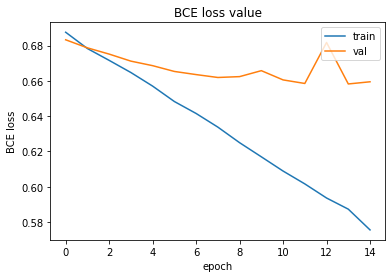

In [43]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

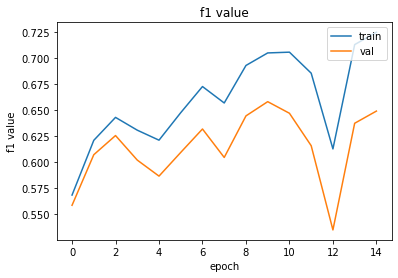

In [44]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [45]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [46]:
fp, fn, tp, tn = predict(model, val_iterator)

In [47]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.6489007943838906

результаты сомнительные...графики тоже не очень, попробуем улучшить модель.

In [ ]:
fn[:5]

['как хотя вы такие что не',
 'ni вообще я залил всю клаву',
 'скучно наверно фильм смотреть хз',
 'же что без тебя серо и будь рядом',
 'вышел с к чтобы конфеты не забрали я всю химию ржу от этих конфет']

### Подгрузим обученные эмбеддинги Fasttext

In [51]:
texts = tweets_data.prep_text.tolist()

In [52]:
ft = FastText(texts, size=100, window=5, min_count=1)

In [53]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [54]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=3, padding='same')
        self.ngrams_cat = nn.Conv1d(in_channels=140, out_channels=140, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=140, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        pooling = self.pooling(self.relu(self.ngrams_cat(concat)))
        bm = pooling.max(2)[0]
        logits = self.hidden(bm) 
        logits = self.out(logits)       
        return logits

In [55]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [56]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7442966571875981
Train loss: 0.7163601640997261
Train loss: 0.7069632370363582
Train loss: 0.7023533663507235
Train loss: 0.6993581507657025

Evaluating on train...
Val loss: 0.7323948528085437, Val f1: 0.598504900932312
Val loss: 0.7067165230882579, Val f1: 0.5763217210769653
Val loss: 0.6987987661903555, Val f1: 0.5676146745681763
Val loss: 0.6950676673549717, Val f1: 0.5615387558937073
Val loss: 0.6929395545173336, Val f1: 0.5599706768989563

Evaluating on test...
Val loss: 0.9164356787999471, Val f1: 0.7162491679191589
Val loss: 0.7848502652985709, Val f1: 0.6162203550338745
Val loss: 0.7486724745143544, Val f1: 0.5904375910758972
Val loss: 0.7319497863451639, Val f1: 0.5784367322921753
Val loss: 0.7218234068468997, Val f1: 0.5725264549255371

starting Epoch 1
Training...
Train loss: 0.7324549768652234
Train loss: 0.7071088758008234
Train loss: 0.6988819959488782
Train loss: 0.6948276515734397
Train loss: 0.6919460715474309

Evaluating on

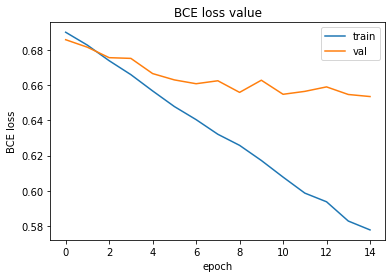

In [57]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

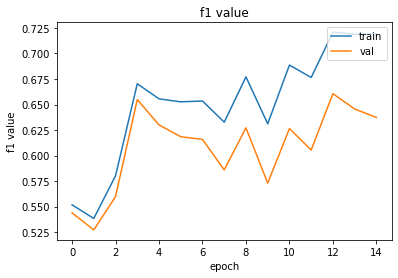

In [58]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [59]:
fp, fn, tp, tn = predict(model, val_iterator)

In [60]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.6371006659588843

In [61]:
fn[:5]

['и сюда хули нет',
 'кааак',
 'утро сейчас в путь дорогу на соревнования небо поможет',
 'давайте посмотрим я вот вчера все части',
 'вы с утра пока все из дома не и только потом']

Подруженные эмбеддинги не улучшили результаты :(

Попробуем убрать предобработку текстов совсем. От переобучения я уже спасла модель тем, что добавила Dropout, уменьшила embedding_dim до 5, уменьшила in_features (и соответственно out_channels) до 140, разделила текст на train/val как 8 к 2. Learning rate 0.001 тоже помогает улучшить результаты + небольшое кол-во эпох предотвращает переобучение.

In [62]:
vocab = Counter()
for text in tweets_data['text']:
    vocab.update(text.split(' '))
for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [63]:
class RawTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [64]:
train_dataset = RawTweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [65]:
val_dataset = RawTweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [66]:
model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [67]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7425261565617153
Train loss: 0.7124633090249424
Train loss: 0.6997694440863349
Train loss: 0.6904480002694211
Train loss: 0.6820363168780869

Evaluating on train...
Val loss: 0.6817730367183685, Val f1: 0.7031376361846924
Val loss: 0.6557193131282412, Val f1: 0.6798455715179443
Val loss: 0.6484759328040209, Val f1: 0.6727760434150696
Val loss: 0.6449418674081059, Val f1: 0.6678467392921448
Val loss: 0.6430699857505592, Val f1: 0.6665016412734985

Evaluating on test...
Val loss: 0.8452746868133545, Val f1: 0.8745368719100952
Val loss: 0.7282027431896755, Val f1: 0.7428436875343323
Val loss: 0.6947866407307711, Val f1: 0.7065210938453674
Val loss: 0.6780308723449707, Val f1: 0.6947243809700012
Val loss: 0.6687708591160021, Val f1: 0.683219313621521

starting Epoch 1
Training...
Train loss: 0.6709419574056353
Train loss: 0.6441787810161196
Train loss: 0.6326057504523884
Train loss: 0.6231598318633387
Train loss: 0.6159594155646659

Evaluating on

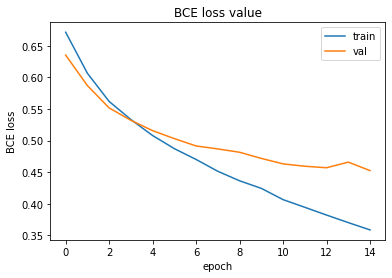

In [68]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

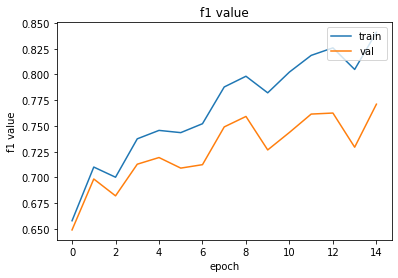

In [69]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [70]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7716295873740254

Результаты стали лучше, ура! По всей видимости, чем больше информации о тексте получает модель, тем лучше она справляется с задачей. Тем более при оценки тональности текстов в соц. сетях нужно учитывать смайлики/знаки препинания/скобки и тд, тк они важные индикаторы "настроения" автора. Посмотрим на ошибки модели.

In [71]:
fp[:5]

['В моем случае только так( @',
 'будешь смогла я',
 'любовь на расстоянии это очень грустно:(',
 ' как конфет с итоге тебя кто - нибудь пошлет и',
 'Сегодня по около в со скоростью в час, ни кто даже не']

In [ ]:
fn[:5]

['скучно наверно фильм смотреть хз',
 'Если какой я с тобой пойду. Хорошо иметь в жизни таких людей, которые способны сказать эти',
 'реквестирую возможность и при этом быть на него а то нихрена не спасает от а',
 'мы то с тобой обязательно',
 'я до "Не выдержала душа']

### Модель с комбинацией эмбеддингов и символьных признаков

In [ ]:
vocab = Counter()
for text in tweets_data['prep_text']:
    vocab.update(text.split())

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

уникальных токенов, втретившихся больше 5 раз: 14917


In [ ]:
char_vocab = Counter()
for text in tweets_data['prep_text']:
    for word in text:
      char_vocab.update(list(word))

filtered_char_vocab = set()

for word in char_vocab:
    if char_vocab[word] > 10:
        filtered_char_vocab.add(word)
print('уникальных токенов, втретившихся больше 10 раз:', len(filtered_char_vocab))

symbol2id = {'PAD':0}

for symbol in filtered_char_vocab:
    symbol2id[symbol] = len(symbol2id)

уникальных токенов, втретившихся больше 10 раз: 73


In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [ ]:
ft_2 = FastText(tweets_data['prep_text'].tolist(), size=100, window=5, min_count=1)

In [ ]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft_2.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [ ]:
class WSTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['prep_text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [ ]:
train_dataset = WSTweetsDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
val_dataset = WSTweetsDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
class WSCNN(nn.Module):
    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

        # word-level
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(100, 100) 

        # symbol-level
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)

        # both
        self.relu = nn.ReLU()   
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5) 
        self.out = nn.Sigmoid()

    def forward(self, words_seq, symb_seq):
        #batch_size x seq_len
        embedded = self.symb_embedding(symb_seq)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded)))) 
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded)))) 
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch_size x (filter_count2 + filter_count3)
        symb_vector = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq) 
        mean_emb_words = torch.mean(embedded_words, dim=1) 
        word_vector = self.dropout(self.word_hidden(mean_emb_words)) # тут был дропаут
        word_vector = self.dropout(self.relu(word_vector)) # тут был дропаут
        concat = torch.cat((symb_vector, word_vector), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (word_seq, symb_seq, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(word_seq, symb_seq)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in enumerate(iterator):   
            preds = model(word_seq, symb_seq)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке


In [ ]:
model = WSCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7970502589430127
Train loss: 0.7439993249958959
Train loss: 0.7234059233557094
Train loss: 0.7108699275275409
Train loss: 0.7016369998455048

Evaluating on train...
Val loss: 0.711431486266, Val f1: 0.7110620141029358
Val loss: 0.6872936487197876, Val f1: 0.6851364374160767
Val loss: 0.6793504817919298, Val f1: 0.6788883805274963
Val loss: 0.6754608750343323, Val f1: 0.6748223900794983
Val loss: 0.6732387301084157, Val f1: 0.6728519797325134

Evaluating on test...
Val loss: 0.8837892214457194, Val f1: 0.8960347175598145
Val loss: 0.758181129183088, Val f1: 0.7598348259925842
Val loss: 0.7235158302567222, Val f1: 0.7296117544174194
Val loss: 0.7083022197087606, Val f1: 0.7111564874649048
Val loss: 0.6997516217984652, Val f1: 0.6997172832489014

starting Epoch 1
Training...
Train loss: 0.7021045429365975
Train loss: 0.6740649239770298
Train loss: 0.6632606807080182
Train loss: 0.6542869483010244
Train loss: 0.6474765716372309

Evaluating on tra

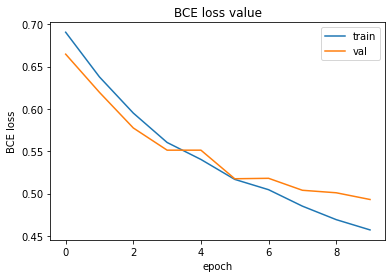

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

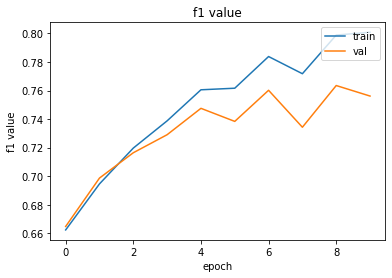

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in enumerate(iterator):  
            preds = model(word_seq, symb_seq)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, word_seq):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7563133185075365

In [ ]:
tp[:5]

['USER давно не вам удачи вперед мои любимые ребята',
 'как дела что делаете как настроение а хотя вы такие пидары что не d',
 'нас уже 1 и так держать мы и дальше будем стараться для вас спасибо что вы с нами URL',
 'USER под тренд пусть лучше он под нас',
 'USER от бизнес школ меня освободили а на 1 пару ехать']

результат неплохой, попробуем убрать препроц + добавить эпох + не обрезать словарь по частотности

In [ ]:
vocab = Counter()
for text in tweets_data['text']:
    vocab.update(text.split())

word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

char_vocab = Counter()
for text in tweets_data['text']:
    for word in text:
      char_vocab.update(list(word))

symbol2id = {'PAD':0}

for symbol in char_vocab:
    symbol2id[symbol] = len(symbol2id)

id2word = {i:word for word, i in word2id.items()}
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [ ]:
print(len(symbol2id), len(word2id))

338 305485


In [ ]:
class WSTweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [ ]:
train_dataset = WSTweetsDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
val_dataset = WSTweetsDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
model = WSCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(15):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7829427548817226
Train loss: 0.7261351840249424
Train loss: 0.6992298594929955
Train loss: 0.6746769416130195
Train loss: 0.6445169565645424

Evaluating on train...
Val loss: 0.4958380460739136, Val f1: 0.9539183378219604
Val loss: 0.47931364692490674, Val f1: 0.9194748997688293
Val loss: 0.4740449874238534, Val f1: 0.909337043762207
Val loss: 0.47069942446078283, Val f1: 0.9060183167457581
Val loss: 0.4695067498329523, Val f1: 0.9026559591293335

Evaluating on test...
Val loss: 0.6200776696205139, Val f1: 1.1890051364898682
Val loss: 0.5320288028035846, Val f1: 1.0152311325073242
Val loss: 0.5070147947831587, Val f1: 0.9716357588768005
Val loss: 0.4958838224411011, Val f1: 0.9492861032485962
Val loss: 0.4894339504994844, Val f1: 0.9364045858383179

starting Epoch 1
Training...
Train loss: 0.4115755132266453
Train loss: 0.3345758858425864
Train loss: 0.2807788750664754
Train loss: 0.24130230838969602
Train loss: 0.2117117068453415

Evaluating

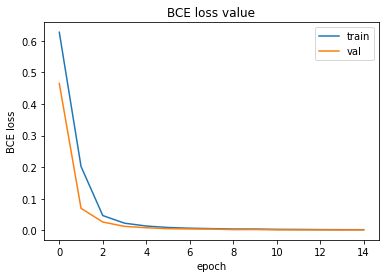

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

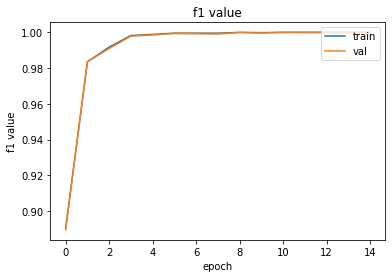

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.999755058051242

результат получился высоким. вывод: скобочки, смайлики и проч. сильно влияют на оценку тональности твитов. текст сам по себе не так важен, как символы, которыми он сопровождается. :)